# 1. Chargements des bibliothéques à utiliser

In [108]:
# importation des modules requis
import numpy as np # calcul scientifique
import pandas as pd # traitement des données, I/O de fichier CSV (par exemple pd.read_csv) 
import matplotlib.pyplot as plt # data viz
import seaborn as sns # data viz
import pickle # Pickle pour décaper (enregistrer) le modèle
from wordcloud import WordCloud # Representation des données
import warnings # ignorer les warnings 
warnings.filterwarnings('ignore')

# Pour le traitement de texte
import nltk # Prétraitement de notre texte
from nltk.corpus import stopwords # supprimer tous les mots vides
from nltk.tokenize import word_tokenize # extraire les TOKENS d'une chaîne de caractères
import re # Regular expression

from sklearn.feature_extraction.text import CountVectorizer # utiliser un BAG de mots qui va convertir le texte en forme binaire
from sklearn.naive_bayes import MultinomialNB # Machine learning algorithme
from sklearn.metrics import classification_report # Créez un rapport texte montrant les principales mesures de classification.
from sklearn.externals import joblib #Joblib est un ensemble d'outils pour fournir un pipelining léger en Python

In [109]:
import sys
print(sys.executable)

C:\ProgramData\Anaconda3\python.exe


# 2. Transformation des données en data Frame

In [110]:
# importation du Dataset
dataframe = pd.read_csv('spam.csv', encoding='latin-1')


In [111]:
# Affichage des données
dataframe.head()

,class,message,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [112]:
# Suppression des colonnes qui n'a pas de sens 
dataframe.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)


In [113]:
# Changeons les noms des colonnes en fonction de leur signification
dataframe.columns = ['class', 'message']

In [114]:
# Affichage des nouveau colonnes
dataframe.head()


,class,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# 3. Visualisation des données(Comprendre les données)

In [115]:
# Le nombre des lignes et colonnes
dataframe.shape

(5572, 2)

In [116]:
# No NaN dans la dataset
dataframe.isna().sum()

class      0
message    0
dtype: int64

In [117]:
# Grouper les donner par class
dataframe.groupby('class').count()


,message
class,
ham,4825
spam,747


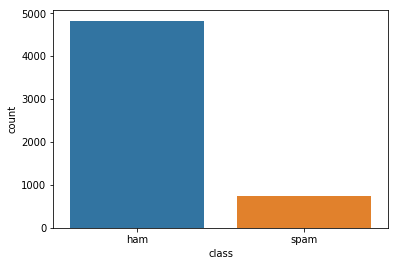

In [118]:
# La distribution des spam et ham
sns.countplot(x='class',data=dataframe)

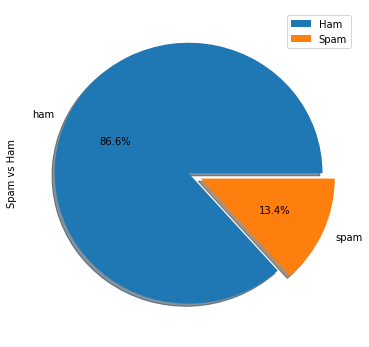

In [119]:
# Ham > spam
message["class"].value_counts().plot(kind = 'pie', explode = [0, 0.1], figsize = (6, 6), autopct = '%1.1f%%', shadow = True)
plt.ylabel("Spam vs Ham")
plt.legend(["Ham", "Spam"])
plt.show()

In [120]:
# Info génerale su la dateset
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
class      5572 non-null object
message    5572 non-null object
dtypes: object(2)
memory usage: 87.1+ KB


In [121]:
dataframe.isna().sum()

class      0
message    0
dtype: int64

In [122]:
# On n'a pas du valeur NaN
dataframe.isnull().sum()

class      0
message    0
dtype: int64

In [123]:
# Vérifions si la longueur de message est corrélée au spam / ham
dataframe['length'] = dataframe['message'].map(lambda text: len(text))

dataframe.groupby('class').length.describe()

,count,mean,std,min,25%,50%,75%,max
class,,,,,,,,
ham,4825.0,71.023627,58.016023,2.0,33.0,52.0,92.0,910.0
spam,747.0,138.866131,29.183082,13.0,132.5,149.0,157.0,224.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000022019026780>,
      dtype=object)

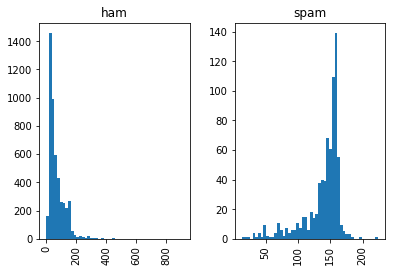

In [124]:
# la longueur des e-mails a des valeurs extrêmes, permet de définir un seuil de longueur et de vérifier la distribution de la longueur
message = dataframe[dataframe.length < 1800]
message.hist(column='length', by='class', bins=50)

# Rien de grand chose ici, traitons maintenant le contenu du courrier pour créer un filtre anti-spam

In [125]:
# Features and Labels
dataframe['label'] = dataframe['class'].map({'ham': 0, 'spam': 1})
X = dataframe['message']
y = dataframe['label']

In [126]:
spam_messages = message[message["class"] == "spam"]["message"]
ham_messages = message[message["class"] == "ham"]["message"]

spam_words = []
ham_words = []

# Since this is just classifying the message as spam or ham, we can use isalpha(). 
# This will also remove the not word in something like can't etc. 
# In a sentiment analysis setting, its better to use 
# sentence.translate(string.maketrans("", "", ), chars_to_remove)

def extractSpamWords(spamMessages):
    global spam_words
    words = [word.lower() for word in word_tokenize(spamMessages) if word.lower() not in stopwords.words("english") and word.lower().isalpha()]
    spam_words = spam_words + words
    
def extractHamWords(hamMessages):
    global ham_words
    words = [word.lower() for word in word_tokenize(hamMessages) if word.lower() not in stopwords.words("english") and word.lower().isalpha()]
    ham_words = ham_words + words

spam_messages.apply(extractSpamWords)
ham_messages.apply(extractHamWords)

0       None
1       None
3       None
4       None
6       None
7       None
10      None
13      None
14      None
16      None
17      None
18      None
20      None
21      None
22      None
23      None
24      None
25      None
26      None
27      None
28      None
29      None
30      None
31      None
32      None
33      None
35      None
36      None
37      None
38      None
        ... 
5538    None
5539    None
5541    None
5542    None
5543    None
5544    None
5545    None
5546    None
5548    None
5549    None
5550    None
5551    None
5552    None
5553    None
5554    None
5555    None
5556    None
5557    None
5558    None
5559    None
5560    None
5561    None
5562    None
5563    None
5564    None
5565    None
5568    None
5569    None
5570    None
5571    None
Name: message, Length: 4825, dtype: object

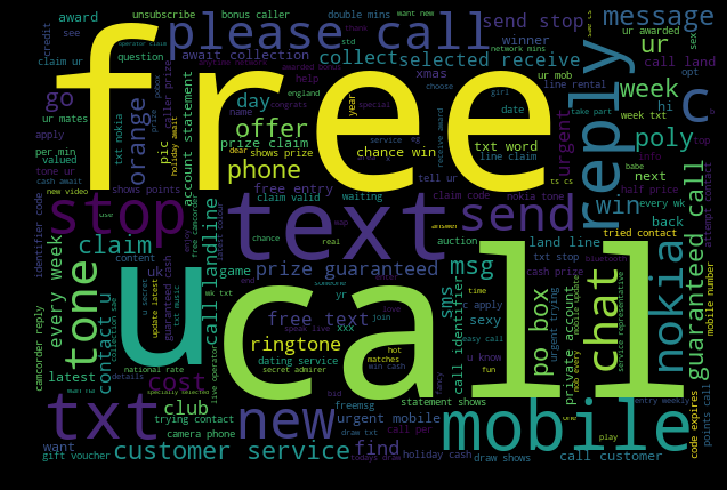

In [127]:
#Spam Word cloud

spam_wordcloud = WordCloud(width=600, height=400).generate(" ".join(spam_words))
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(spam_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

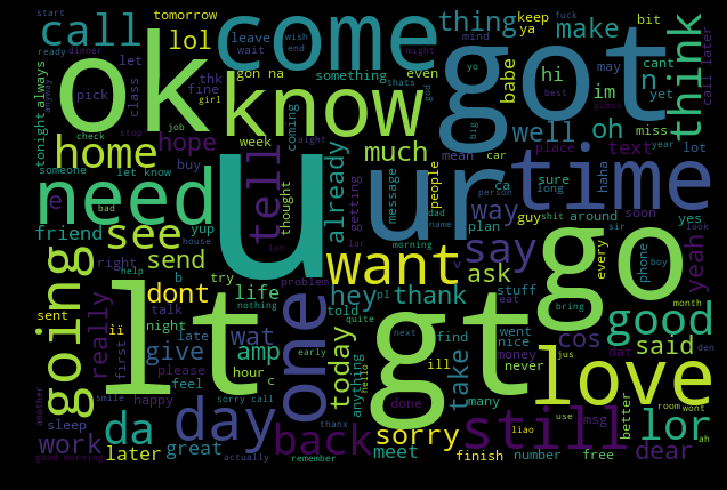

In [128]:
#Ham word cloud

ham_wordcloud = WordCloud(width=600, height=400).generate(" ".join(ham_words))
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(ham_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

# 4. Nettoyage Des données

In [129]:
def pre_process(text):
    
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = [word for word in text.split() if word.lower() not in stopwords.words('english')]
    words = ""
    for i in text:
            stemmer = SnowballStemmer("english")
            words += (stemmer.stem(i))+" "
    return words

# 5. Transformation (word to vector) Tokenization & Vectorization

In [130]:
# Extract Feature With CountVectorizer
cv = CountVectorizer()
X = cv.fit_transform(X) # Fit the Data

# 6. Train Test Split

In [131]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [132]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3733, 8672)
(1839, 8672)
(3733,)
(1839,)


# 7. Paramétré l'algorithme d'apprentissage

In [133]:
**Random Forest

SyntaxError: invalid syntax (<ipython-input-133-e9f214ea2bfd>, line 1)

In [134]:
# Fitting Naive Bayes to the Training set

from sklearn.ensemble import RandomForestClassifier


In [135]:
#Apprentissage

cl=RandomForestClassifier()
cl.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [136]:
# Predicting the Test set results

y_pred = cl.predict(X_test)

In [137]:
# Validation par des mesures de performances

from sklearn.metrics import confusion_matrix,accuracy_score


In [138]:
cm2 = confusion_matrix(y_test, y_pred)
print('Accuracy: ', accuracy_score(y_test, y_pred) * 100)

Accuracy:  96.79173463839042


In [139]:
**Naive_bayes

SyntaxError: invalid syntax (<ipython-input-139-f6ca147cf78e>, line 1)

In [140]:
# Fitting Naive Bayes to the Training set

from sklearn.naive_bayes import MultinomialNB

# 8. Apprentissage

In [141]:
#Naive Bayes Classifier

clf = MultinomialNB()
clf.fit(X_train,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

# 9. Prediction

In [142]:

#y_pred=clf.score(X_test,y_test)
y_pred_dt = clf.predict(X_test)


# 10. Validation par des mesures de performances

In [143]:
# Matrice de confusion
cm = confusion_matrix(y_test, y_pred_dt)

print(cm)

[[1569   18]
 [  20  232]]


In [144]:
# Accuracy
print ("Accuracy : %0.5f \n\n" % accuracy_score(y_test, clf.predict(X_test)))
print (classification_report(y_test, clf.predict(X_test)))

Accuracy : 0.97934 


             precision    recall  f1-score   support

          0       0.99      0.99      0.99      1587
          1       0.93      0.92      0.92       252

avg / total       0.98      0.98      0.98      1839



# 11. Creating a pickle file for the Multinomial Naive Bayes model


In [145]:
#Alternative Usage of Saved Model
joblib.dump(clf, 'spam_model.pkl')
joblib.dump(cv, 'cv.pkl')

['cv.pkl']